In [1]:
import pandas as pd
import numpy as np

import seaborn as sn
from matplotlib import pyplot as plt

import copepodTCR as cpp
import codepub as cdp

import tqdm
import time

# Figure-2: Fluorescent microscopy read out.

In [2]:
exp_data_m = pd.read_csv('./data/M_TCR6_YLQ_activation.tsv',
                      sep = "\t")
cpp_scheme = pd.read_csv('./data/epitope_simulation_results.tsv', sep = "\t")
peptides = list(pd.read_csv('./data/peptides.tsv', sep = "\t", header = None)[0])

ep_length = 8
n_pools = 12
iters = 4

### TCR6_3

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [negative, offset_proportion, p, sigma_neg, sigm_pos, pool_dist, sigma_data]
>BinaryGibbsMetropolis: [assign]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.
/Users/kovaleva/miniforge3/envs/copepodTCR/lib/python3.10/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
Sampling: [lik, negative_obs]


Output()

Posterior mean of p: 0.582
No drop-outs were detected
['CTFEYVSQPFLMDLEGK', 'SSANNCTFEYVSQPFLM']
['CTFEYVSQPFLMDLEGK', 'SSANNCTFEYVSQPFLM']


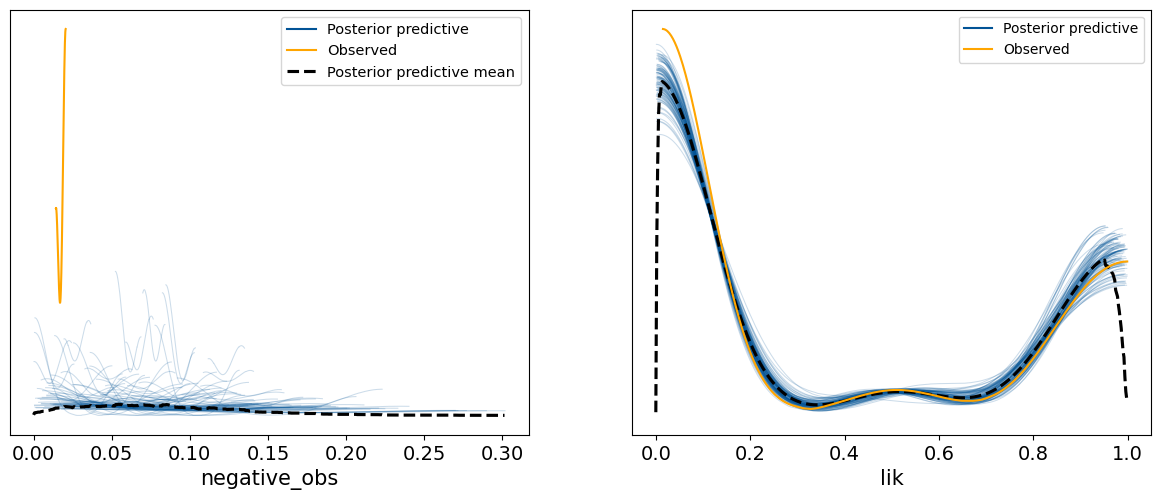

In [3]:
obs = np.array(exp_data_m['TCR6_3_m(#)'][exp_data_m['type'] == 'pool'])
inds = np.array(exp_data_m['Pool'][exp_data_m['type'] == 'pool']).astype(int)
neg_f1 = np.array(exp_data_m['TCR6_3_m(#)'][exp_data_m['Pool'] == 'unstim'])

t, r = cpp.how_many_peptides(peptides, ep_length)
e = max(t, key=t.get)
neg_share = (n_pools - iters - e + 1)/n_pools

model, fig, probs, n_c, pp, parameters = cpp.activation_model(obs, n_pools, inds, neg_f1, neg_share = neg_share)
peptide_probs = cpp.peptide_probabilities(cpp_scheme, probs)
n_act_pools, message, most, possible = cpp.results_analysis(peptide_probs, probs, cpp_scheme)
print(message)
print(most)
print(possible)

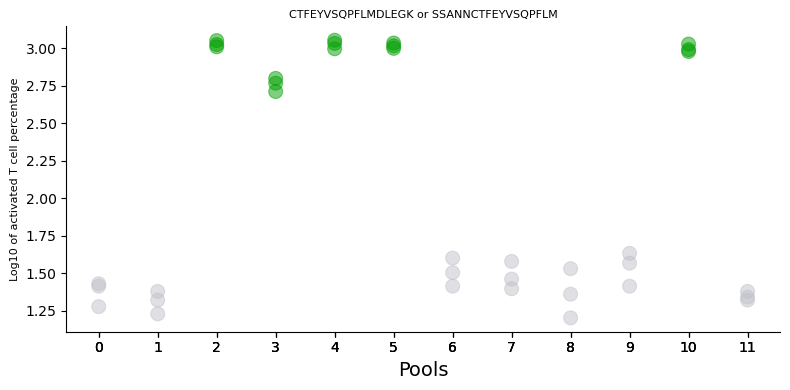

In [4]:
cpp.poolplot(probs, obs, inds, most)

### YLQ_TCR1

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [negative, offset_proportion, p, sigma_neg, sigm_pos, pool_dist, sigma_data]
>BinaryGibbsMetropolis: [assign]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [lik, negative_obs]


Output()

Posterior mean of p: 0.592
Drop-out was detected
['YVGYLQPRTFLLKYNEN', 'GAAAYYVGYLQPRTFLL']
['SLIDLQELGKYEQYIKW', 'ATKMSECVLGQSKRVDF', 'KNLNESLIDLQELGKYE', 'GAAAYYVGYLQPRTFLL', 'YVGYLQPRTFLLKYNEN', 'SGWTAGAAAYYVGYLQP', 'ECVLGQSKRVDFCGKGY']


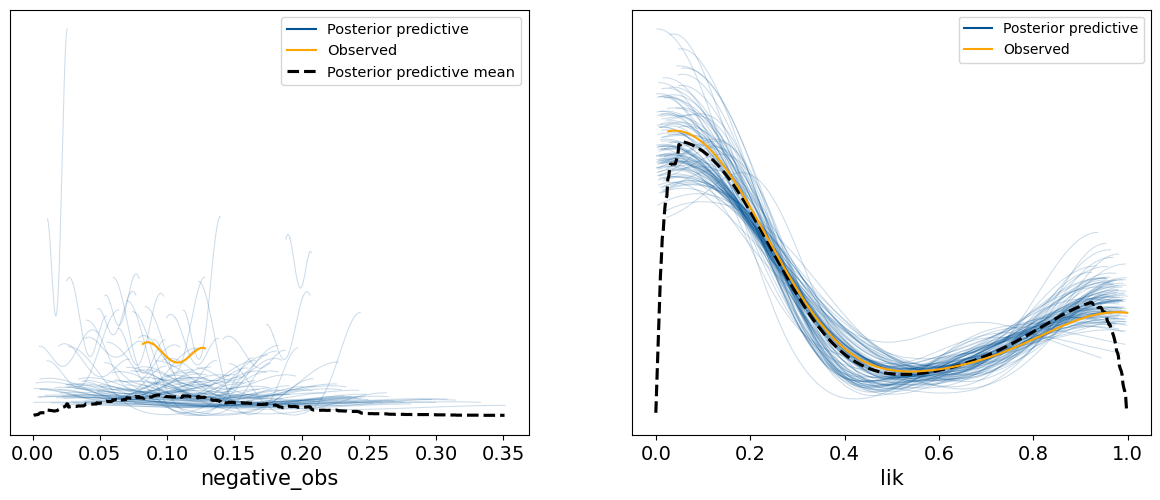

In [5]:
obs = np.array(exp_data_m['YLQ_TCR1_m(#)'][exp_data_m['type'] == 'pool'])
inds = np.array(exp_data_m['Pool'][exp_data_m['type'] == 'pool']).astype(int)
neg_f1 = np.array(exp_data_m['YLQ_TCR1_m(#)'][exp_data_m['Pool'] == 'unstim'])

t, r = cpp.how_many_peptides(peptides, ep_length)
e = max(t, key=t.get)
neg_share = (n_pools - iters - e + 1)/n_pools

model, fig, probs, n_c, pp, parameters = cpp.activation_model(obs, n_pools, inds, neg_f1, neg_share = neg_share)
peptide_probs = cpp.peptide_probabilities(cpp_scheme, probs)
n_act_pools, message, most, possible = cpp.results_analysis(peptide_probs, probs, cpp_scheme)
print(message)
print(most)
print(possible)

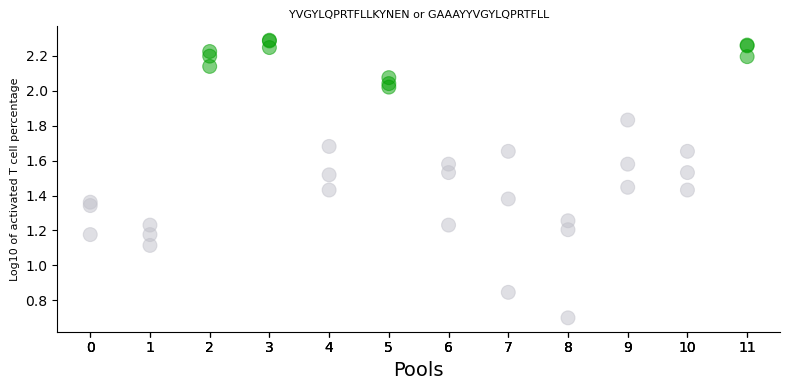

In [6]:
cpp.poolplot(probs, obs, inds, most)

# Figure-5: Activation model predictions on synthetic data.

In [7]:
table = pd.read_csv('./data/insilico_validation.tsv',
                    sep = "\t", low_memory=False)
control = table[table['error'] == 100]
table = table[table['error'] != 100]
print(f'Negative data: {len(control)}')
print(f'Data: {len(table)}')

Negative data: 6480
Data: 12960


**Figure-5A** Sensitivity and specificity of the activation model with parameters for negative distribution inferred from separate negative control data (with, TPR/FPR) or from the pool with the lowest activation signal (without, TPR_n/FPR_n). The model's performance in both scenarios depends on signal intensity ($mu_{signal}$, representing the difference in percentage of activated cells between positive and negative distributions), where in simulations with a weak signal ($mu_{signal} = 5$), the sensitivity of the model is higher with a separate negative control, but specificity is lower.

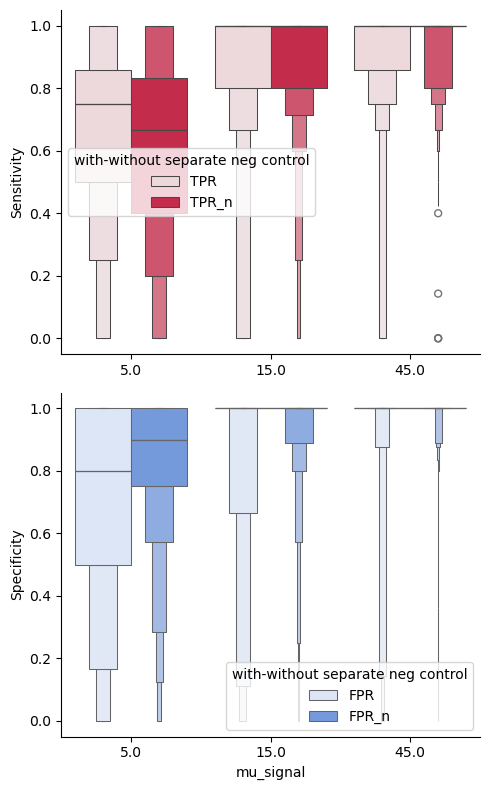

In [8]:
fig, axes = plt.subplots(2, 1, figsize = (5, 8))

ax = axes[0]
d1 = pd.melt(table[['TPR', 'TPR_n', 'mu_signal']], id_vars=['mu_signal'], 
             value_vars=['TPR', 'TPR_n'],
             var_name='with-without separate neg control',
             value_name='TPR_all')
sn.boxenplot(data = d1, y = 'TPR_all', x = 'mu_signal', hue = 'with-without separate neg control',
             ax = ax, palette = ['#F0D5DA', '#DC143C'])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('')

ax = axes[1]
d1 = pd.melt(table[['FPR', 'FPR_n', 'mu_signal']], id_vars=['mu_signal'], 
             value_vars=['FPR', 'FPR_n'],
             var_name='with-without separate neg control',
             value_name='FPR_all')
sn.boxenplot(y = 1- d1['FPR_all'], x = d1['mu_signal'], hue = d1['with-without separate neg control'],
             ax = ax, palette = ['#D8E5FB', '#6495ED'])
ax.set_ylabel('Specificity')

sn.despine()
plt.tight_layout()

**Figure-5B** Sensitivity and specificity of the activation model are similar across simulations with different numbers of replicates per pool (1, 2, or 3 replicates). Sensitivity slightly increases with the number of replicates per pool (upper panel), but specificity decreases (lower panel), especially with weak signal (lower panel, $mu_{signal} = 5$.)

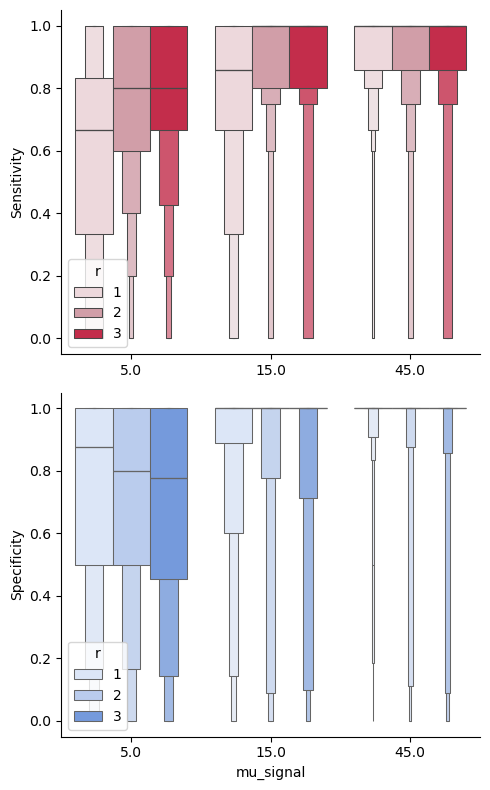

In [9]:
fig, axes = plt.subplots(2, 1, figsize = (5, 8))

ax = axes[0]
d1 = table
sn.boxenplot(data = d1, y = 'TPR', x = 'mu_signal', hue = 'r', ax = ax, palette = ['#F0D5DA', '#DA95A3', '#DC143C'])
ax.set_ylabel('Sensitivity')
ax.set_xlabel('')

ax = axes[1]
sn.boxenplot(y = 1- d1['FPR'], x = d1['mu_signal'], hue = d1['r'], ax = ax, palette = ['#D8E5FB', '#B1CAF6', '#6495ED'])
ax.set_ylabel('Specificity')


plt.tight_layout()
sn.despine()